Credit Loan Decisions
=====================


This notebook is one of the tutorials from [fairlearn](https://fairlearn.org/) library. See the original tutorial with detailed explanations here: <https://fairlearn.org/main/auto_examples/plot_credit_loan_decisions.html#sphx-glr-download-auto-examples-plot-credit-loan-decisions-py> The original tutorial was using Microsoft's LightGB (which has limited support for Linux and Windows machines). I switched to sklearn's default GB to make it easier (or fairer!) to start development for all users.

**Check the related standards before the development process**

| Fairness terminology| Management and governance | Measurement and test | Performance requirements |
---- | ---- | ---- | ----|
| IEEE P7003 | ISO/IEC 42001 | ISO/IEC TR 24027 | ISO/IEC TR 24027 |
| ISO/IEC TR 24027 | ISO/IEC 23894 | ISO/IEC TS 12791 | ISO/IEC 12791 |
| | ISO 31000 | | |

Package Imports
===============


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore")

rand_seed = 1234
np.random.seed(rand_seed)

## Fairness considerations of credit loan decisions

In 2019, Apple received backlash on social media after its newly launched *Apple Card* product appeared to offer higher credit limits to
men compared to women.

**Check this incident on AI Incidents Database:** <https://incidentdatabase.ai/cite/92/#r2035>

From a regulatory perspective, financial institutions are subject to *legal regulations* prohibiting discrimination on the [basis of race, gender, or other protected classes.

This case study replicates the work done in a white paper ([Assessing and mitigating unfairness in credit models with the Fairlearn toolkit](https://www.microsoft.com/en-us/research/uploads/prod/2020/09/Fairlearn-EY_WhitePaper-2020-09-22.pdf)), on mitigating gender-related performance disparities in financial lending decisions.

### Credit decisions dataset

This notebook uses a publicly available dataset of credit card defaults in Taiwan collected in 2005. This dataset represents binary credit card default outcomes for 30,000 applicants with information pertaining to an applicant\'s payment history and bill statements over a six-month period from April 2005 to September 2005, as well as demographic information, such as *sex*, *age*, *marital status*, and *education level* of the applicant. A full summary of features is provided below:


|features | description |
---- | ---- |
| sex, education, marriage, age                 | demographic features |
| pay\_0, pay\_2, pay\_3, pay\_4, pay\_5, pay\_6| repayment status (ordinal) |
| bill\_amt1, bill\_amt2, bill\_amt3, bill\_amt4, bill\_amt5, bill\_amt\_6   | bill statement amount (Taiwan dollars) | 
| pay\_amt1, pay\_amt2, pay\_amt3, pay\_amt4, pay\_amt5, pay\_amt6           | previous statement amount (Taiwan dollars)| 
| default payment next month                    | default information (1 = YES, 0 = NO) | 


A positive prediction by the model means the applicant would default on the credit loan. *Defaulting on a loan* means the client fails to make payments within a 30-day window, and the lender can take legal actions against the client. Although we do not have a dataset of loan default history, we do have this data set of credit card payment history. We assume customers who make monthly credit card payments on time are more *creditworthy*, and thus less likely to default on a personal credit loan.

**Decision point: task definition**

- **Defaulting on a credit card payment** can be viewed as a proxy for the fact that an applicant might not be a good candidate for a personal loan.
- Because most customers did not default on their credit card payment, we will need to take this class imbalance into account during our modeling process.

As the data is read in-memory, we will change the column `PAY_0` to `PAY_1` to make the naming more consistent with the naming of the other columns. In addition, the target variable `default payment next month` is changed to `default` to reduce verbosity.


In [2]:
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 

default_of_credit_card_clients.data.features.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [15]:
import sys
sys.path.append('../../')
from faid import logging as faidlog
faidlog.init_log()

Model log file created.
Data log file created.
Risks log file created.
Transparency log file created.


In [4]:
print(type(default_of_credit_card_clients.metadata))
print(type(default_of_credit_card_clients.variables))

<class 'ucimlrepo.dotdict.dotdict'>
<class 'pandas.core.frame.DataFrame'>


In [5]:
default_of_credit_card_clients.variables.head()

,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,None,None,no
1,X1,Feature,Integer,None,LIMIT_BAL,None,no
2,X2,Feature,Integer,Sex,SEX,None,no
3,X3,Feature,Integer,Education Level,EDUCATION,None,no
4,X4,Feature,Integer,Marital Status,MARRIAGE,None,no


In [6]:
import json
# Convert metadata to JSON
metadata_json = json.dumps(default_of_credit_card_clients.metadata)
# Convert JSON back to dictionary
metadata_dict = json.loads(metadata_json)

# Show first five entities
list(metadata_dict.items())[:5]

[('uci_id', 350),
 ('name', 'Default of Credit Card Clients'),
 ('repository_url',
  'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients'),
 ('data_url', 'https://archive.ics.uci.edu/static/public/350/data.csv'),
 ('abstract',
  "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.")]

In [7]:
list(metadata_dict.items())[:5]

[('uci_id', 350),
 ('name', 'Default of Credit Card Clients'),
 ('repository_url',
  'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients'),
 ('data_url', 'https://archive.ics.uci.edu/static/public/350/data.csv'),
 ('abstract',
  "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.")]

When you download a dataset from UCI ML Datasets repository, the dataset record comes with a standardised metadata like above JSON output. You can find details about this standardised format here: <https://github.com/uci-ml-repo/ucimlrepo/blob/main/README.md> 

Below, we listed fairness-related data you can find in this metadata:

| **entity** | **explanation** | **fairness** |
| ----------------  | ---------------- | ---------------- |
| dataset.headers | Headers of dataset features | protected characteristics can be extracted from features |
| dataset.targets   | Dataframe of target columns                     | Representativeness of subgroups based on features can be extracted                 |
| variables.demographic                          | Indicates whether the variable represents demographic data                   | If any direct or proxy variable is stored, inform it here                          |
| variables. missing_values                      | Whether there are missing values in the variable's column                    | Representativeness should be calculated and normalised based on missing value count|
| metadata.additional_info.purpose               | For what purpose was the dataset created?       | Compare it with the EU AI Act risky applications      |
| metadata.additional_info.sensitive_data        | Does the dataset contain data that might be considered sensitive in any way? | All sensitive data should be explained here           |
| metadata.additional_info.instances_represented | What do the instances in this dataset represent?| I would personally assume you could find most information in purpose and sensitive_data part, but check if any useful information available. |

Now, let's see if the metadata is already filled with these information:

In [8]:
# Represented features
default_of_credit_card_clients.data.headers

Index(['ID', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'Y'],
      dtype='object')

In [9]:
# Normalised value counts
default_of_credit_card_clients.data.targets.value_counts(normalize=True)

Y
0    0.7788
1    0.2212
Name: proportion, dtype: float64

In [10]:
default_of_credit_card_clients.variables["demographic"]

0                None
1                None
2                 Sex
3     Education Level
4      Marital Status
5                 Age
6                None
7                None
8                None
9                None
10               None
11               None
12               None
13               None
14               None
15               None
16               None
17               None
18               None
19               None
20               None
21               None
22               None
23               None
24               None
Name: demographic, dtype: object

In [11]:
default_of_credit_card_clients.variables["missing_values"]

0     no
1     no
2     no
3     no
4     no
5     no
6     no
7     no
8     no
9     no
10    no
11    no
12    no
13    no
14    no
15    no
16    no
17    no
18    no
19    no
20    no
21    no
22    no
23    no
24    no
Name: missing_values, dtype: object

In [12]:
# Now let's see if we can extract any useful information from the metadata
print(metadata_dict["additional_info"]["purpose"])
print(metadata_dict["additional_info"]["sensitive_data"])
print(metadata_dict["additional_info"]["instances_represent"])

None
None
None


In [16]:
from faid.logging import pretty_uci_metadata

pretty_metadata = pretty_uci_metadata(metadata_dict)
pretty_metadata

{'id': 350,
 'description': {'dataset_name': 'Default of Credit Card Clients',
  'dataset_link': 'https://archive.ics.uci.edu/static/public/350/data.csv',
  'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients',
  'intro_paper': {'ID': 365,
   'type': 'NATIVE',
   'title': 'The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients',
   'authors': 'I. Yeh, Che-hui Lien',
   'venue': 'Expert systems with applications',
   'year': 2009,
   'journal': None,
   'DOI': '10.1016/j.eswa.2007.12.020',
   'URL': 'https://www.semanticscholar.org/paper/1cacac4f0ea9fdff3cd88c151c94115a9fddcf33',
   'sha': None,
   'corpus': None,
   'arxiv': None,
   'mag': None,
   'acl': None,
   'pmid': None,
   'pmcid': None},
  'authors': ['I-Cheng Yeh'],
  'summary': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six d

In [ ]:
# For each key value pair in the metadata dictionary, add it to the data log directly, without creating a Data Card object
for key, value in pretty_metadata.items():
    faidlog.add_data_entry(key=key, entry=value)

Added id to data card
Added description to data card
Added content to data card
Added descriptive_statistics to data card
Added sensitive_data to data card
Added version_details to data card


In [16]:
faidlog.get_fairness_entities_from_data()

{'summary': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.",
 'protected_characteristics': ['Sex',
  'Education Level',
  'Marital Status',
  'Age'],
 'intentional_sensitive_data': None,
 'unintentional_sensitive_data': [],
 'rai': {'dataCollection': '',
  'dataCollectionType': '',
  'dataCollectionRawData': '',
  'dataAnnotationProtocol': '',
  'dataAnnotationPlatform': '',
  'dataAnnotationAnalysis': '',
  'dataUseCases': '',
  'dataBiases': '',
  'annotationsPerItem': '',
  'annotatorDemographics': ''}}

In [18]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (
    pd.read_excel(io=data_url, header=1)
    .drop(columns=["ID"])
    .rename(
        columns={"PAY_0": "PAY_1", "default payment next month": "default"}
    )
)

dataset.shape

(30000, 24)

In [19]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


We see ```metadata_dict["demographics"]``` there are three categorical features related to demographics:
-   `SEX`: Sex of the applicant (as a binary feature)
-   `EDUCATION`: Highest level of education achieved by the applicant.
-   `MARRIAGE`: Marital status of the applicant.


In [20]:
# Now, let's create a data card object to update the data log in the rest of this notebook
datacard = faidlog.DataCard()
datacard.set_sensitive_data({"protected_characteristics": metadata_dict["demographics"]})

In [22]:
# You can see that data card object initiated with the existing data log and added the sensitive data
datacard.to_dict()

{'id': 350,
 'description': {'name': '',
  'summary': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.",
  'dataset_link': 'https://archive.ics.uci.edu/static/public/350/data.csv',
  'repository_link': '',
  'intro_paper': {'ID': 365,
   'type': 'NATIVE',
   'title': 'The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients',
   'authors': 'I. Yeh, Che-hui Lien',
   'venue': 'Expert systems with applications',
   'year': 2009,
   'journal': None,
   'DOI': '10.1016/j.eswa.2007.12.020',
   'URL': 'https://www.semanticscholar.org/paper/1cacac4f0ea9fdff3cd88c151c94115a9fddcf33',
   'sha': None,
   'corpus': None,
   'arxiv': None,
   'mag': None,
   'acl': None,
   'pmid': None,
   'pmcid': None},
  'publishing_organization': '',
  'tasks': ['Classification'],
  'characteristics': ['Multivariate'],
  'feature_t

In [23]:
fairness_log = faidlog.FairnessExperimentRecord("credit-scoring-default")
fairness_log.add_data_entry(key="protected_characteristics", entry=metadata_dict["demographics"])

Added protected_characteristics to project metadata under ['data'] and log updated


In [24]:
categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]

for col_name in categorical_features:
    dataset[col_name] = dataset[col_name].astype("category")

Y, A = dataset.loc[:, "default"], dataset.loc[:, "SEX"]
X = pd.get_dummies(dataset.drop(columns=["default", "SEX"]))

A_str = A.map({1: "male", 2: "female"})

Dataset imbalances
==================

Before we start training a classifier model, we want to explore the
dataset for any characteristics that may lead to fairness-related harms
later on in the modeling process. In particular, we will focus on the
distribution of sensitive feature `SEX` and the target label `default`.

As part of an exploratory data analysis, let\'s explore the distribution
of our sensitive feature `SEX`. We see that 60% of loan applicants were
labeled as [female]{.title-ref} and 40% as [male]{.title-ref}, so we do
not need to worry about imbalance in this feature.


In [22]:
A_str.value_counts(normalize=True)

SEX
female    0.603733
male      0.396267
Name: proportion, dtype: float64

Next, let\'s explore the distribution of the *loan default rate* `Y`. We
see that around 78% of individuals in the dataset do not default on
their credit loan. While the target label does not display extreme
imbalance, we will need to account for this imbalance in our modeling
section. As opposed to the *sensitive feature* `SEX`, an imbalance in
the target label may result in a classifier that over-optimizes for the
majority class. For example, a classifier that predicts an applicant
will not default would achieve an accuracy of 78%, so we will use the
`balanced_accuracy` score as our evaluation metric to counteract the
label imbalance.


In [23]:
Y.value_counts(normalize=True)

default
0    0.7788
1    0.2212
Name: proportion, dtype: float64

Add synthetic noise that is related to the outcome and sex
==========================================================

For the purpose of this case study, we add a synthetic feature
`Interest` that introduces correlation between the `SEX` label of an
applicant and the `default` outcome. The purpose of this feature is to
replicate outcome disparities present in the original dataset. We can
think of this `Interest` feature as the *interest rate* for the
applicant. If the applicant has a history of defaulting on credit card
payments, the bank will lend to the applicant at a higher interest rate.
We also assume because banks have historically lended primarily to men,
there is less uncertainty (or variance) in the *interest rate* for these
applicants.

To reflect the above reasoning, the `Interest` feature is drawn from a
*Gaussian distribution* with the following criterion:

-   If *Male*, draw `Interest` from
    $\mathcal{N}(2 \cdot \text{Default}, 1)$
-   If *Female*, draw `Interest` from
    $\mathcal{N}(2 \cdot \text{Default}, 2)$

This feature is drawn from a *Gaussian distribution* for computational
simplicity.


In [24]:
X.loc[:, "Interest"] = np.random.normal(loc=2 * Y, scale=A)

Check if this will lead to disparity in naive model
===================================================

Now that we have created our synthetic feature, let\'s check how this
new feature interacts with our *sensitive\_feature* `Sex` and our target
label `default`. We see that for both sexes, the `Interest` feature is
higher for individuals who defaulted on their loan.


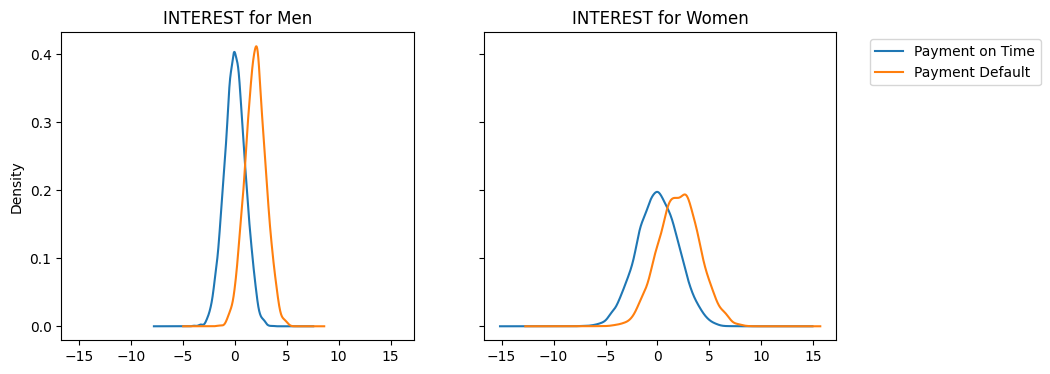

In [25]:
fig, (ax_1, ax_2) = plt.subplots(
    ncols=2, figsize=(10, 4), sharex=True, sharey=True
)
X["Interest"][(A == 1) & (Y == 0)].plot(
    kind="kde", label="Payment on Time", ax=ax_1, title="INTEREST for Men"
)
X["Interest"][(A == 1) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_1
)
X["Interest"][(A == 2) & (Y == 0)].plot(
    kind="kde",
    label="Payment on Time",
    ax=ax_2,
    legend=True,
    title="INTEREST for Women",
)
X["Interest"][(A == 2) & (Y == 1)].plot(
    kind="kde", label="Payment Default", ax=ax_2, legend=True
).legend(bbox_to_anchor=(1.6, 1))

Training an initial model
=========================

In this section, we will train a fairness-unaware model on the training
data. However because of the imbalances in the dataset, we will first
resample the training data to produce a new balanced training dataset.


In [26]:
def resample_training_data(X_train, Y_train, A_train):
    """Down-sample the majority class in the training dataset to produce a
    balanced dataset with a 50/50 split in the predictive labels.

    Parameters:
    X_train: The training split of the features
    Y_train: The training split of the target labels
    A_train: The training split of the sensitive features

    Returns:
    Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    """
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids))
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [27]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.35, stratify=Y
)

X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

At this stage, we will train a *gradient-boosted tree classifier* using
the `lightgbm` package on the balanced training dataset. When we
evaluate the model, we will use the unbalanced testing dataset.


In [28]:
gb_params = {
    "learning_rate": 0.03,
    "min_samples_leaf": 10,
    "max_depth": 3,
    "random_state": rand_seed,
}

estimator = Pipeline(
    steps=[
        ("preprocessing", StandardScaler()),
        ("classifier", GradientBoostingClassifier(**gb_params)),
    ]
)

estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            min_samples_leaf=10,
                                            random_state=1234))])

In [29]:
from faid.logging import ModelCard
m = ModelCard()

Model info is loaded from the model log file.


In [30]:
m.to_dict()

{'model_details': {'name': '',
  'overview': None,
  'documentation': None,
  'owners': [{'name': '', 'contact': ''}],
  'version': {'name': None, 'date': None, 'diff': None},
  'license': {'identifier': None, 'custom_text': None},
  'references': None,
  'citation': None,
  'path': None},
 'model_parameters': {'description': None,
  'model_architecture': {'learning_rate': 0.03,
   'min_samples_leaf': 10,
   'max_depth': 3,
   'random_state': 1234},
  'data': [{'description': '',
    'link': None,
    'sensitive': None,
    'graphics': None}],
  'input_format': None,
  'output_format': None,
  'output_format_map': None},
 'quantitative_analysis': {'description': None,
  'performance_metrics': [{'description': None,
    'value': None,
    'slice': None,
    'confidence_interval': {'description': 'Explain your interval selection methodology. e.g. <https://fairlearn.org/v0.11/user_guide/assessment/confidence_interval_estimation.html>',
     'lower_bound': None,
     'upper_bound': None}},

In [31]:
m.model_params_schema

{'description': '',
 'model_architecture': '',
 'data': [{'description': '', 'link': '', 'sensitive': '', 'graphics': ''}],
 'input_format': '',
 'output_format': '',
 'output_format_map': ''}

In [32]:
m.set_model_parameters(parameter_key="model_architecture", parameter_value=gb_params)

In [33]:
m.save()

Model info saved to the model log file.


We compute the *binary predictions* and the *prediction probabilities*
for the testing data points.


In [34]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = estimator.predict(X_test)

From the *ROC Score*, we see the model appears to be differentiating
between *true positives* and *false positives* well. This is to be
expected given the `INTEREST` feature provides a strong discriminant
feature for the classification task.


In [35]:
roc_auc_score(y_test, Y_pred_proba)

0.8783381576296417

In [36]:
m.performance_metric_schema

{'description': '',
 'value': '',
 'slice': '',
 'confidence_interval': {'description': '',
  'lower_bound': '',
  'upper_bound': ''}}

In [37]:
from sklearn.utils import resample

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

# Bootstrap the ROC AUC score
for i in range(n_bootstraps):
    indices = resample(range(len(y_test)), random_state=rng_seed + i)
    if len(np.unique(y_test.iloc[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        continue

    score = roc_auc_score(y_test.iloc[indices], Y_pred_proba[indices])
    bootstrapped_scores.append(score)

# Compute the confidence interval
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# 95% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

print(f"95% confidence interval for the ROC AUC score: [{confidence_lower:.3f} - {confidence_upper:.3f}]")

95% confidence interval for the ROC AUC score: [0.870 - 0.887]


In [38]:
m.add_quantitative_analysis_metric({
    'description': 'ROC AUC Score is the area under the ROC curve',
    'value': '0.878',
    'slice': '',
    'confidence_interval': 
        {'description': '.95 confidence interval for the ROC AUC score',
        'lower_bound': '0.870',
        'upper_bound': '0.887'}
})

In [39]:
m.save()
# Don't forget to save the model card after adding the metric. The following method will automatically scan the model log file.

Model info saved to the model log file.


In [ ]:
from faid.scan import test_model_quantitative_metrics

test_model_quantitative_metrics()

Model info is loaded from the model log file.
Model info is loaded from the model log file.
model_parameters: {'data': [{'description': '', 'link': '', 'sensitive': '', 'graphics': ''}]}
quantitative_analysis: {'description': '', 'performance_metrics': [{'description': '', 'value': '', 'slice': '', 'confidence_interval': {'description': '', 'lower_bound': '', 'upper_bound': ''}}]}
considerations: {'description': '', 'intended_users': '', 'use_cases': '', 'limitations': '', 'tradeoffs': '', 'ethical_considerations': '', 'risks': [{'name': '', 'mitigation_strategy': ''}]}
Checking metric: None. The metric description: 
Value for None is within the confidence interval


In [1]:
import sys
sys.path.append('../../')

In [2]:
from faid.logging import get_fairness_entities_from_model

get_fairness_entities_from_model()

Model info is loaded from the model log file.
Model info: {'description': None, 'model_architecture': {'learning_rate': 0.03, 'min_samples_leaf': 10, 'max_depth': 3, 'random_state': 1234}, 'data': [{'description': '', 'link': None, 'sensitive': None, 'graphics': None}], 'input_format': None, 'output_format': None, 'output_format_map': None}


{'model_parameters': {'data': [{'description': '',
    'link': None,
    'sensitive': None,
    'graphics': None}]},
 'quantitative_analysis': {'description': None,
  'performance_metrics': [{'description': None,
    'value': None,
    'slice': None,
    'confidence_interval': {'description': 'Explain your interval selection methodology. e.g. <https://fairlearn.org/v0.11/user_guide/assessment/confidence_interval_estimation.html>',
     'lower_bound': None,
     'upper_bound': None}},
   {'description': 'ROC AUC Score is the area under the ROC curve',
    'performance_metrics': [...],
    'value': '0.878',
    'slice': '',
    'confidence_interval': {'description': '.95 confidence interval for the ROC AUC score',
     'lower_bound': '0.870',
     'upper_bound': '0.887'}},
   {'description': 'ROC AUC Score is the area under the ROC curve',
    'performance_metrics': [...],
    'value': '0.878',
    'slice': '',
    'confidence_interval': {'description': '.95 confidence interval for the R

Feature Importance of the Unmitigated Classifier
================================================

As a model validation check, let\'s explore the feature importances of
our classifier. As expected, our synthetic feature `INTEREST` has the
highest feature importance because it is highly correlated with the
target variable, by construction.


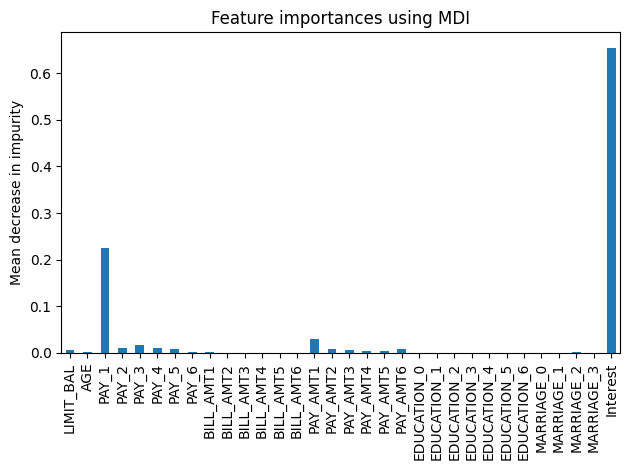

In [24]:
importances = estimator.steps[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in estimator.steps[1][1].estimators_[0]], axis=0)
feature_names = X_train.columns
gb_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
gb_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Fairness assessment of unmitigated model
========================================

Now that we have trained our initial fairness-unaware model, let\'s
perform our fairness assessment for this model. When conducting a
fairness assessment, there are three main steps we want to perform:

1.  Identify who will be harmed.
2.  Identify the types of harms we anticipate.
3.  Define fairness metrics based on the anticipated harms.

Who will be harmed?
-------------------

Based on the incident with *Apple* credit card mentioned at the
beginning of this notebook, we believe the model may incorrectly predict
women will default on the credit loan. The system may unfairly allocate
less loans to women and over-allocate loans to men.


Types of harm experienced
=========================

When discussing fairness in AI systems, the first step is understanding
what types of harms we anticipate the system may produce. Using the
`harms taxonomy in the Fairlearn User Guide <types_of_harms>`{.interpreted-text
role="ref"}, we expect this system to produce *harms of allocation*. In
addition, we also anticipate the long-term impact on an individual\'s
credit score if an individual is unable to repay a loan they receive or
if they are rejected for a loan application. A *harm of allocation*
occurs when an AI system extends or withholds resources, opportunities,
information. In this scenario, the AI system is extending or withholding
financial assets from individuals. A review of historical incidents
shows these types of automated lending decision systems may discriminate
unfairly based on sex.

**Negative impact of credit score**

A secondary harm that is somewhat unique to credit lending decisions is
the long-term impact on an individual\'s credit score. In the United
States, a [FICO credit
score](https://www.investopedia.com/terms/c/credit_score.asp) is a
number between 300 and 850 that represents a customer\'s
*creditworthiness*. An applicant\'s *credit score* is used by many
financial institutions for lending decisions. An applicant\'s *credit
score* usually increases after a successful repayment of a loan and
decreases if the applicant fails to repay the loan.

When applying for a credit loan, there are three major outcomes:

1.  The individual receives the credit loan and pays back the loan. In
    this scenario, we expect the individual\'s credit score to increase
    as a result of the successful repayment of the loan.
2.  The individual receives the credit loan but defaults on the loan. In
    this scenario, the individual\'s credit score will drop drastically
    due to the failure to repay the loan. In the modeling process, this
    outcome is tied to a **false negative** (the model predicts the
    individual will repay the loan, but the individual is unsuccessful
    in doing so).
3.  In certain countries, such as the United States, an individual
    receives a small drop (up to five points) to their credit score
    after a lender performs a *hard inquiry* on the applicant\'s credit
    history. If the applicant applies for a loan but does not receive
    it, the small decrease in their credit score will impact their
    ability to successfully apply for a future loan. In the modeling
    process, this outcome is tied to the **selection rate** (the
    proportion of positive predictions outputted by the model).

**Prevention of wealth accumulation**

One other type of harm we anticipate in this scenario is the long-term
effects of *denying loans to applicants who would have successfully paid
back the loan*. By receiving a loan, an applicant is able to purchase a
home, start a business, or pursue some other economic activity that they
are not able to do otherwise. These outcomes are tied to **false
positive error** rates in which the model predicts an applicant will
default on the loan, but the individual would have successfully paid the
loan back. In the United States, the practice of redlining
`peyton2020redlining`{.interpreted-text role="footcite"}, denying
mortgage loans and other financial services to predominantly Black or
other minority communities, has resulted in a vast racial wealth gap
between white and Black Americans. Although the practice of redlining
was banned in 1968 with the *Fair Housing Act*, the long-term impact of
these practices `jan2018redlining`{.interpreted-text role="footcite"} is
reflected in the lack of economic investment in Black communities, and
Black applicants are denied loans at a higher rate compared to white
Americans.

Define fairness metrics based on harms
--------------------------------------

Now that we have identified the relevant harms we anticipate users will
experience, we can define our fairness metrics. In addition to the
metrics, we will quantify the uncertainty around each metric using
*custom functions* to compute the *standard error* for each metric at
the $\alpha=0.95$ confidence level.


In [25]:
def compute_error_metric(metric_value, sample_size):
    """Compute standard error of a given metric based on the assumption of
    normal distribution.

    Parameters:
    metric_value: Value of the metric
    sample_size: Number of data points associated with the metric

    Returns:
    The standard error of the metric
    """
    metric_value = metric_value / sample_size
    return (
        1.96
        * np.sqrt(metric_value * (1.0 - metric_value))
        / np.sqrt(sample_size)
    )


def false_positive_error(y_true, y_pred):
    """Compute the standard error for the false positive rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn + fp)


def false_negative_error(y_true, y_pred):
    """Compute the standard error for the false negative rate estimate."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn + tp)


def balanced_accuracy_error(y_true, y_pred):
    """Compute the standard error for the balanced accuracy estimate."""
    fpr_error, fnr_error = false_positive_error(
        y_true, y_pred
    ), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2) / 2


fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error,
}

Select a subset of metrics to report to avoid information overload


In [26]:
metrics_to_report = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate",
]

To compute the disaggregated performance metrics, we will use the
`MetricFrame` object within the Fairlearn library. We will pass in our
dictionary of metrics `fairness_metrics`, along with our test labels
`y_test` and test predictions `Y_pred`. In addition, we pass in the
*sensitive\_features* `A_test` to disaggregate our model results.

Instantiate the MetricFrame for the unmitigated model


In [27]:
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=Y_pred,
    sensitive_features=A_test,
)

metricframe_unmitigated.by_group[metrics_to_report]

metricframe_unmitigated.difference()[metrics_to_report]

metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy      0.801575
false_positive_rate    0.213037
false_negative_rate    0.183814
dtype: float64

In [28]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
    """Plot the disaggregated metric for each group with an associated
    error bar. Both metric and the error bar are provided as columns in the
    provided MetricFrame.

    Parameters
    ----------
    metricframe : MetricFrame
        The MetricFrame containing the metrics and their associated
        uncertainty quantification.
    metric : str
        The metric to plot
    error_name : str
        The associated standard error for each metric in metric

    Returns
    -------
    Matplotlib Plot of point estimates with error bars
    """
    grouped_metrics = metricframe.by_group
    point_estimates = grouped_metrics[metric]
    error_bars = grouped_metrics[error_name]
    lower_bounds = point_estimates - error_bars
    upper_bounds = point_estimates + error_bars

    x_axis_names = [
        str(name) for name in error_bars.index.to_flat_index().tolist()
    ]
    plt.vlines(
        x_axis_names,
        lower_bounds,
        upper_bounds,
        linestyles="dashed",
        alpha=0.45,
    )
    plt.scatter(x_axis_names, point_estimates, s=25)
    plt.xticks(rotation=0)
    y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(
        max(upper_bounds), decimals=2
    )
    plt.yticks(np.arange(y_start, y_end, 0.05))
    plt.ylabel(metric)

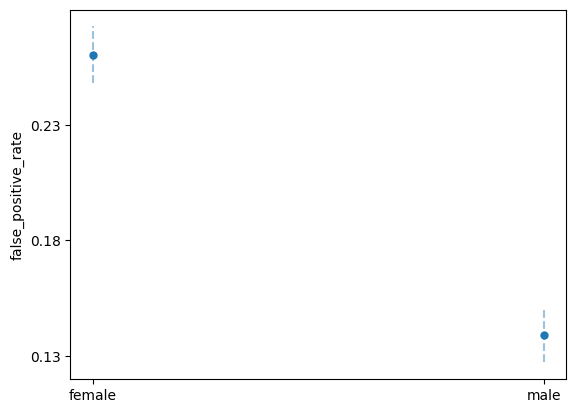

In [29]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_positive_rate", "false_positive_error"
)

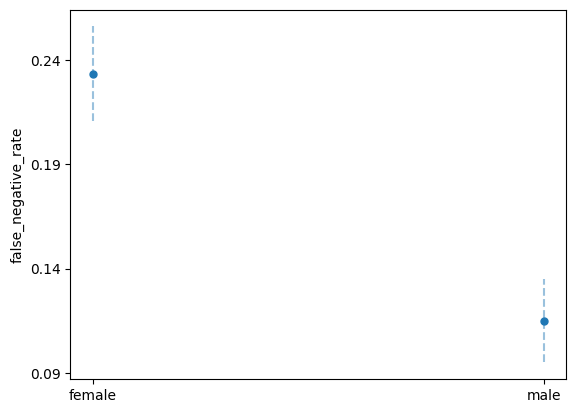

In [30]:
plot_group_metrics_with_error_bars(
    metricframe_unmitigated, "false_negative_rate", "false_negative_error"
)

array([[<Axes: title={'center': 'balanced_accuracy'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_positive_rate'}, xlabel='SEX'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

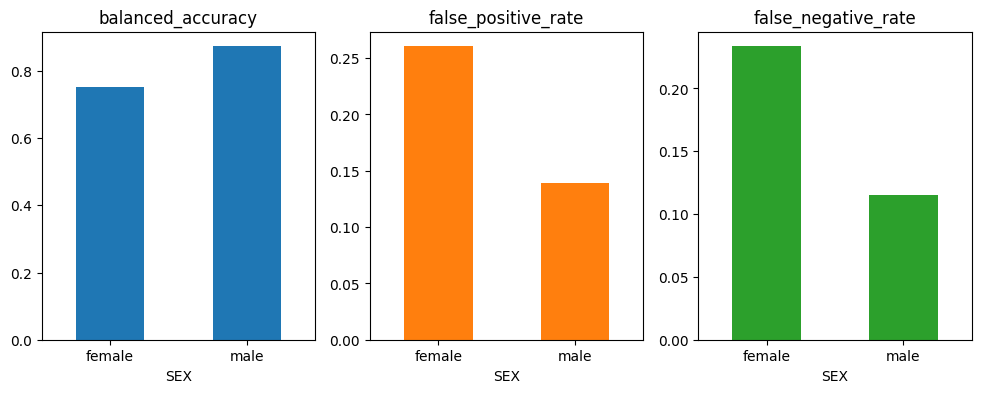

In [31]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(
    subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
)

Finally, let\'s compute the `equalized_odds_difference` for this
unmitigated model. The `equalized_odds_difference` is the maximum of the
`false_positive_rate_difference` and `false_negative_rate_difference`.
In our lending context, both *false\_negative\_rate\_disparities* and
*false\_positive\_rate\_disparities* result in fairness-related harms.
Therefore, we attempt to minimize both of these metrics by minimizing
the `equalized_odds_difference`.


In [32]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated = equalized_odds_difference(
    y_test, Y_pred, sensitive_features=A_test
)

One key assumption here is we assume that *false positives* and *false
negatives* have the equally adverse costs to each group. In practice, we
would develop some weighting mechanism to assign a weight to each *false
negative* and *false positive* event.